# Color Project (Group 9)
Zabi Azimy, Tim Bischoff, Yvan Oliver, Paul Wecker

## Table of Contents:
1. [Task Overview](#overview)
2. [Loading and Transforming Data](#loading)
    1. [Helper functions](#functions)
    2. [Loading, Preprocessing](#prep)
3. [Figures and Interpretations](#three)
    1. [Boxplots for each color value](#3.1)
    2. [Histograms for $\Delta$ e Values for each color spot](#3.2)
    3. [Boxplot for $\Delta$ e Values for each color spot](#3.3)
    4. [Scatter: print master vs measurements](#3.4)
    5. [Standard Deviations of color values (L, a, b)](#3.4)
4. [Conclusion](#four)


## 1 Introduction <a class="anchor" id="overview"></a>

In this short report, we tried to make use of small multiples, box plots, histograms and scatter plots in order to shine some light on the douglas color card data set. The dataset comprises a first half, a "master print" card which stores color values which are to be printed on a card with 64 color spots. The second half is made up of the measurements of the then printed cards. The colors are individualised by their `L`, `a` and `b` values, where `L` stands for how bright the color is, `a` for the proportion of red-green color and `b` for the proportion of blue-yellow color. We used small multiples to do justice to the numerous color spots on the color cards. To reference the actual color card which is printed, we adapted our visualisations accordingly. Later on, we move to a more abstract analysis based on clustering and standard deviations to highlight relations between color groups and dispersions.

Use visualization tools for describing what’s going on in these data. Possible aspects:
- How do colors behave relative to the print master?
    - on individual scales L, a, b?
    - in 3-dimensional "L-a-b" space?
- How does color dispersion behave?
    - on individual scales L, a, b?
    - in 3-dimensional "L-a-b" space?
- It may be of interst to familiarize yourself with delta-E values
- Is the behavior differntial between targets?
- Is the behavior differential between color spots?
- Is quality possibly related to the intended color?
Make use of "small multiples" in useful ways.

## 2 Loading and Transforming Data

This section may be completely overread if you are interested in code or how we prepared our data. We load libraries, data, preprocess it and define helper functions.


### 2.1 Helper functions and imports <a class="anchor" id="functions"></a>

Here, we merely import necessary libraries and define helper functions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import copy
import colorspacious as cs
from sklearn.cluster import KMeans

from typing import Tuple, List

In [3]:
def delta_e(L, a, b, L_m, a_m, b_m):
    return np.sqrt( (L-L_m)**2 + (a-a_m)**2 + (b-b_m)**2)

In [4]:
def create_scatter_data(master_colors: pd.DataFrame,
                        measurements: pd.DataFrame,
                        color: str) -> Tuple[List,List]:
    x = []
    y = []
    for row in range(1,9):
        for col in range(1,9):
            x += [master_colors.loc[(row, col)][color]]*546
            y += measurements[color+str(row)+str(col)].to_list()
    return x, y

In [5]:
def create_scatter_data_std(df_stds: pd.DataFrame,
                            master_colors: pd.DataFrame,
                            color: str
                            ) -> Tuple[List, List]:
    x = []
    y = []
    c = []
    for row, col in master_colors.index:
        x.append(master_colors.loc[(row, col)][color])
        y.append(df_stds[(df_stds["rows"]==row)&(df_stds["cols"]==col)][f"std_{color}"])
        c.append(master_colors.loc[row, col]["cluster"])
    return x, y, c

### 2.2 Load data and preprocessing <a class="anchor" id="prep"></a>

This subsection merely contains loading data, and preprocessing it. For later plots.

#### Tims Preprocessing

In [6]:
measurments = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
master_colors = pd.read_csv("data/MasterColorCard.csv", decimal=',', sep=';')

# make multilevel index for measurments columns
row = measurments['Row']
col = measurments['Column']
measurments = measurments.drop(['Row', 'Column'], axis=1)
new_cols = pd.MultiIndex.from_tuples(
    [(int(col[1:]), col[0]) for col in measurments.columns]
)
measurments.columns = new_cols
measurments.insert(0, 'Row', row)
measurments.insert(1, 'Column', col)

# make multilevel index for master color rows
master_colors.set_index(['Crow', 'Ccol'], inplace=True)

Delta-E values for 3 dimensional analysis

In [7]:
# compute delta e values for each color spot
delta_e_values = np.zeros((546, 64))

min_error = 0
max_error = 0

for i in range(546):
    j = 0
    for row in range(1,9):
        for col in range(1,9):
            spot = row*10+col
            L_master = master_colors.loc[row, col]['L']
            a_master = master_colors.loc[row, col]['a']
            b_master = master_colors.loc[row, col]['b']

            L = measurments.loc[i, (spot, 'L')]
            a = measurments.loc[i, (spot, 'a')]
            b = measurments.loc[i, (spot, 'b')]

            delta_e_values[i, j] = delta_e(L, a, b, L_master, a_master, b_master)
            j += 1

Error computation for each color value (L, a, b)

In [8]:
# compute errors for L, a and b
errors = copy(measurments)
for row in range(1,9):
    for col in range(1,9):
        spot = row*10+col

        master_L = master_colors.loc[row, col]['L']
        master_a = master_colors.loc[row, col]['a']
        master_b = master_colors.loc[row, col]['b']

        errors.loc[:, (spot, 'L')] = errors.loc[:, (spot, 'L')] - master_L
        errors.loc[:, (spot, 'a')] = errors.loc[:, (spot, 'a')] - master_a
        errors.loc[:, (spot, 'b')] = errors.loc[:, (spot, 'b')] - master_b

#### Pauls Preprocessing

Compute standard deviations

In [9]:
measurements = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
rows = []
cols = []
std_L = []
std_a = []
std_b = []
for row in range(1,9):
    for col in range(1,9):
        std_L.append(measurements["L"+str(row)+str(col)].std())
        std_a.append(measurements["a"+str(row)+str(col)].std())
        std_b.append(measurements["b"+str(row)+str(col)].std())
        rows.append(row)
        cols.append(col)
df_stds = pd.DataFrame(data={"rows":rows,
                             "cols":cols,
                             "std_L":std_L,
                             "std_a":std_a,
                             "std_b":std_b})

Remove color spots which are duplicated (only grey, but there are many)

In [10]:
grouped = master_colors.groupby(['L', 'a', 'b'])['Field'].apply(list).reset_index()
grey_fields =grouped.loc[17]["Field"]
master_colors_filtered = master_colors[~master_colors["Field"].isin(grey_fields)]

Plot Elbow Chart for K-Means on remaining colors

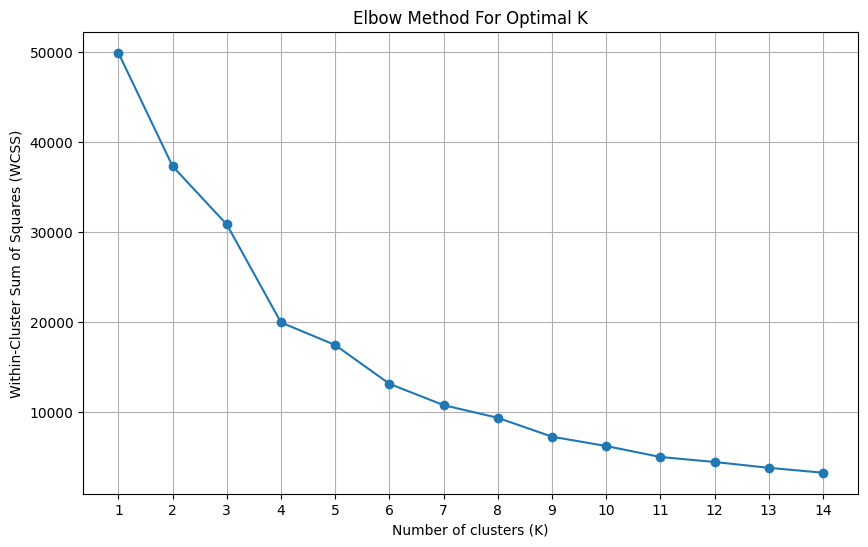

In [11]:
X = master_colors_filtered[['L', 'a', 'b']]

# Compute WCSS for different values of K
wcss = []
K_range = range(1, 15)  # Testing K from 1 to 10

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Assign clusters with K=4, due the "elbow". The "elbow" point signifies a decent trade off between within-cluster-distance and number of clusters. A low within-cluster-distance makes the clusters look more cluster like as points are close to each other. However, this distance is easy to minimize by adding more and more clusters. The elbow point gives this trade-off.

In [12]:
kmeans = KMeans(n_clusters=4, random_state=0)
master_colors_filtered["cluster"] = kmeans.fit_predict(X)

/tmp/ipykernel_2911/1463118047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_colors_filtered["cluster"] = kmeans.fit_predict(X)


## 3 Figures and interpretation <a class="anchor" id="three"></a>

#### 3.1 Boxplot of the errors of each color value (L, a, b) for each color spot <a class="anchor" id="3.1"></a>
In this figure we aim to display the individual errors for L, a and b of each color spot using boxplots. One boxplot is generated with the background color corresponding to the master color. The spots are ordered the same way the color cards are, with grey circles in the corner. To make the boxes more visible on a colored background we decided to color them white if the L (light) value of the master color is less then 47, else we color it black. This way a dark background has a white box and a light background a black box. The value 47 is based on several tests where we discussed wether the boxes were properly visible.
To make the individual color spots more easy to compare we use the same y-scale for each of them. This way you can see that most color spots have errors averaging around zero with little variation. Some spots show greater errors, such as spot 32 for example, which shows the greatest error in all of the color spots.

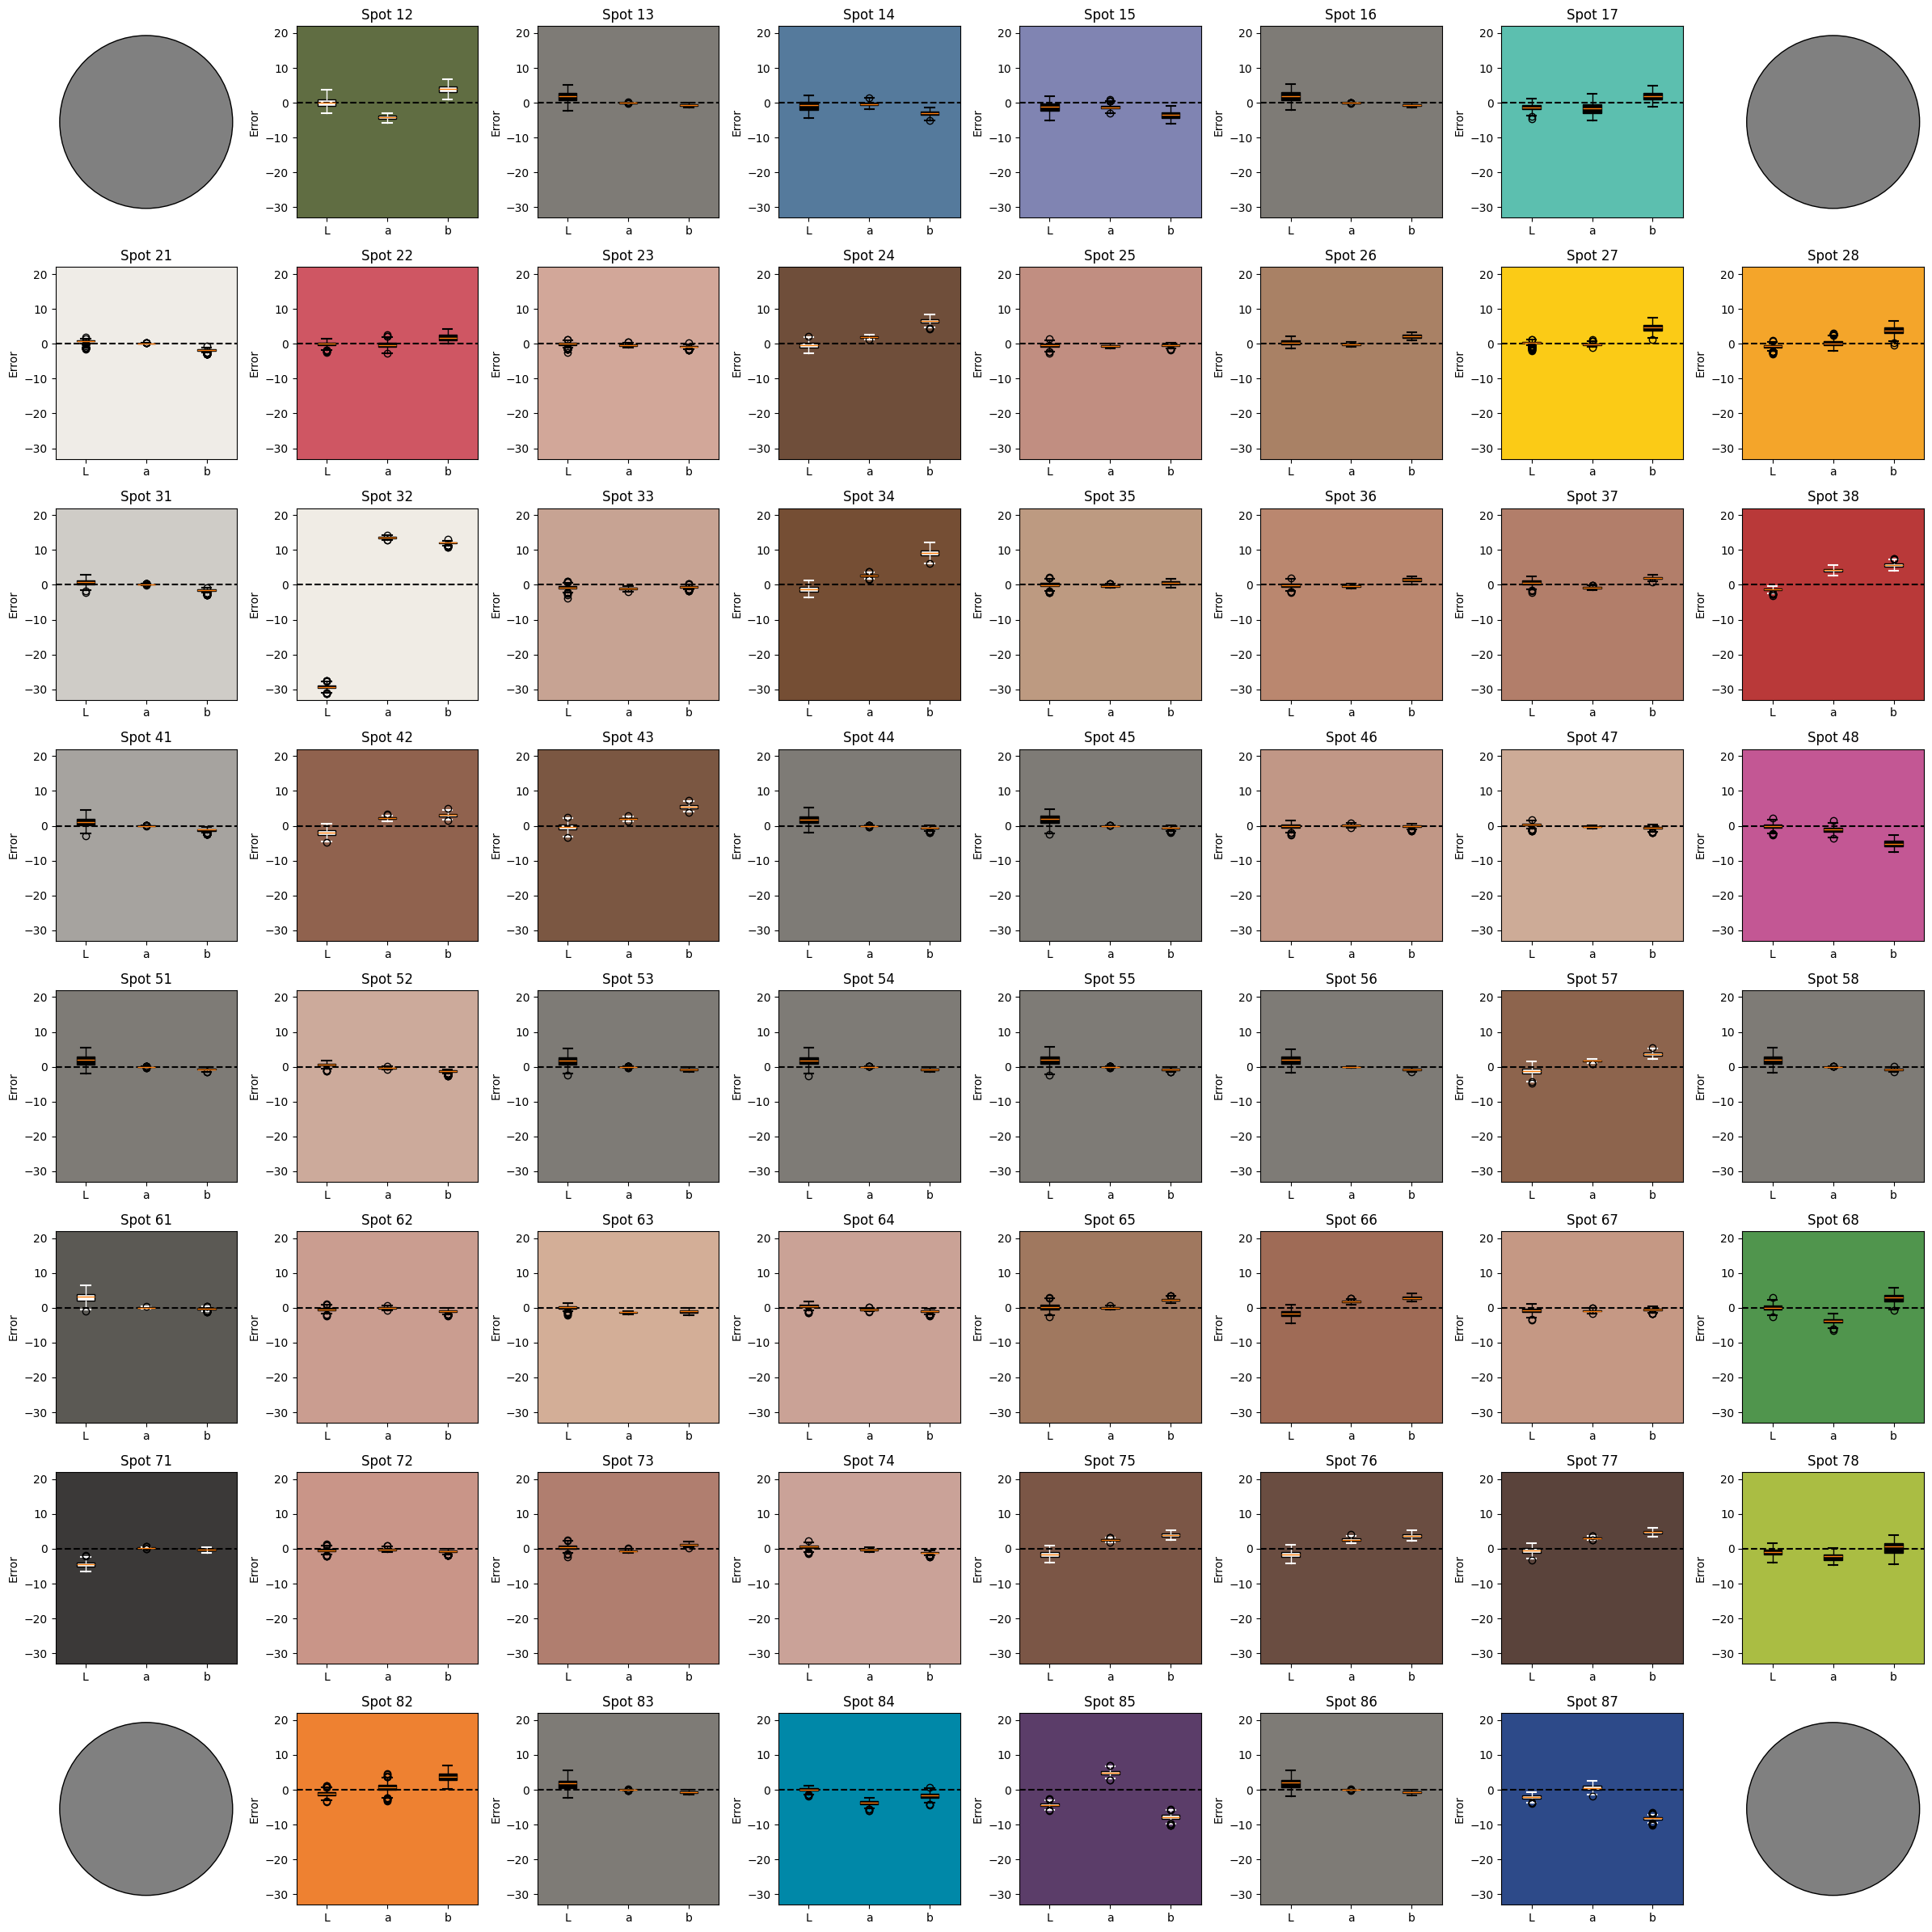

In [13]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

# TODO: use distinct colors for boxplots, they sometimes blend into the background

for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L = errors[spot]['L'].values
        a = errors[spot]['a'].values
        b = errors[spot]['b'].values

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)

        box_color = 'white' if L_master < 47 else 'black'
        edge_color = 'black' if L_master < 47 else 'white'
        bplt = ax.boxplot([L,a,b], patch_artist=True)

        for patch in bplt['boxes']:
            patch.set_facecolor(box_color)
        for whisker in bplt['whiskers']:
            whisker.set(color=box_color, linewidth=1)
        for flier in bplt['fliers']:
            flier.set(marker='o', color=box_color)
        for cap in bplt['caps']:
            cap.set(color=box_color, linewidth=1.5)

        # format plot
        ax.set_facecolor(master_color)
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xticks([1,2,3], ['L', 'a', 'b'])
        ax.set_ylabel('Error')
        ax.set_title(f"Spot {spot}")
        ax.set_ylim([-33, 22])

plt.tight_layout()
plt.savefig("figures/boxplots.png")

#### 3.2 Histograms of $\Delta$ E Values for each color spot  <a class="anchor" id="3.2"></a>
As the $\delta$ e values are apparently very important we decided to also plot their distribution for each color spot. For this we were able to use the same structure as in the boxplots, just using histograms. With this we ran into the issue that, due to the small size of each individual plot, the width of the bars of the histograms became very small which lead to indistinct plots. To combat this we implemented a custom solution which generates an outline around the entire historgram which re

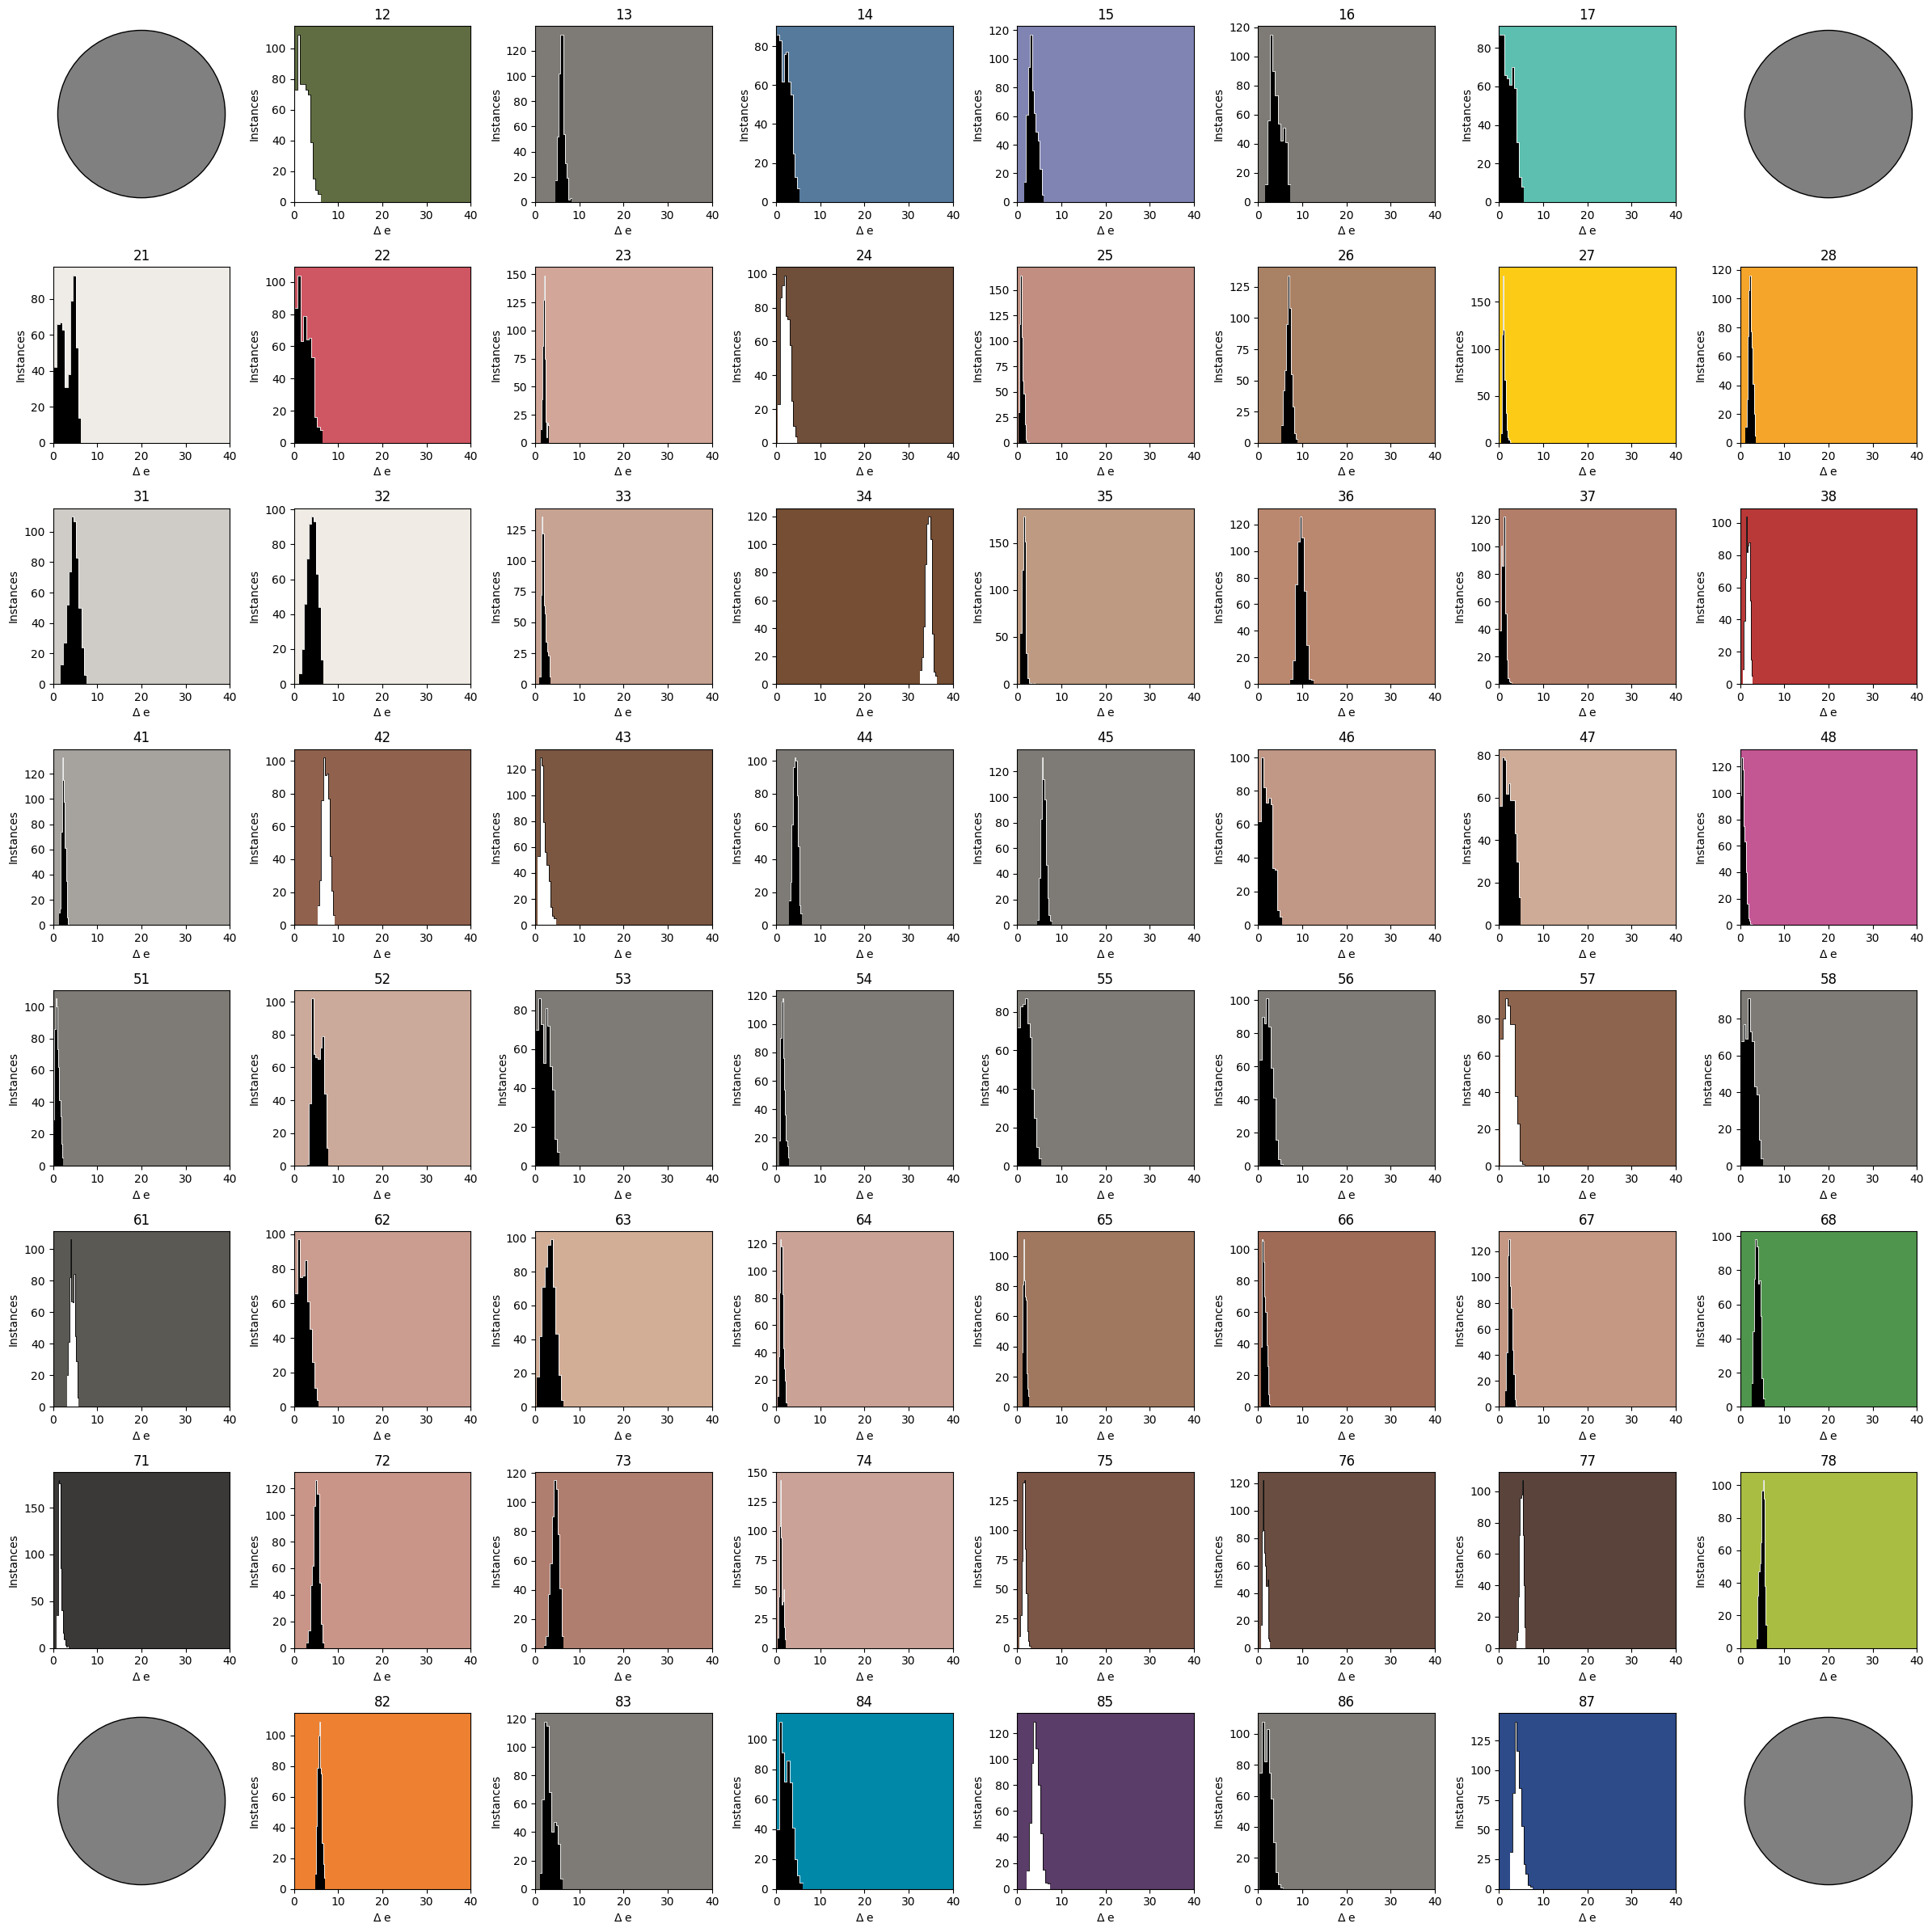

In [54]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

max_error = np.max(delta_e_values)

j = 0
for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)
        ax.set_facecolor(master_color)

        hist_color = 'white' if L_master < 47 else 'black'
        edge_color = 'black' if L_master < 47 else 'white'

        # plot historgram
        n, bins, bars = ax.hist(delta_e_values[:, j], color=hist_color)

        # create outline around plot
        x_ = []
        y_ = []
        for bar in bars:
            x, y = bar.get_xy()
            width = bar.get_width()
            height = bar.get_height()
            x_.append(x)
            y_.append(height)
            x_.append(x + width)
            y_.append(height)
        ax.plot(x_, y_, color=edge_color, linewidth=0.6)

        ax.set_xlim([0, 40])
        ax.set_ylabel('Instances')
        ax.set_xlabel(r'$\Delta$ e')
        ax.set_title(str(spot))
        j += 1

plt.tight_layout()
plt.savefig('figures/delta_e_hists.png')

#### 3.3 Boxplot for $\Delta$-E values for each color spot  <a class="anchor" id="3.3"></a>

The figure generated below, yields the boxplots for the  $\delta$-E values for each color spot. The scale of the Y-axis is the same for all "small multiples" with the exception of the box plot for color spot number 34 as the $\delta$-E value of spot 34 is an outlier for which the scale from 0 to 10 does not suffice.

For the plots themselves, it becomes clear (like above) that not all color spots have the same errors. Even for color spots with the same target color (grey) we have different errors. Notable spots are as mentioned #34 with a really high error, while spot #48 displays a rather low error with its unique pink color.

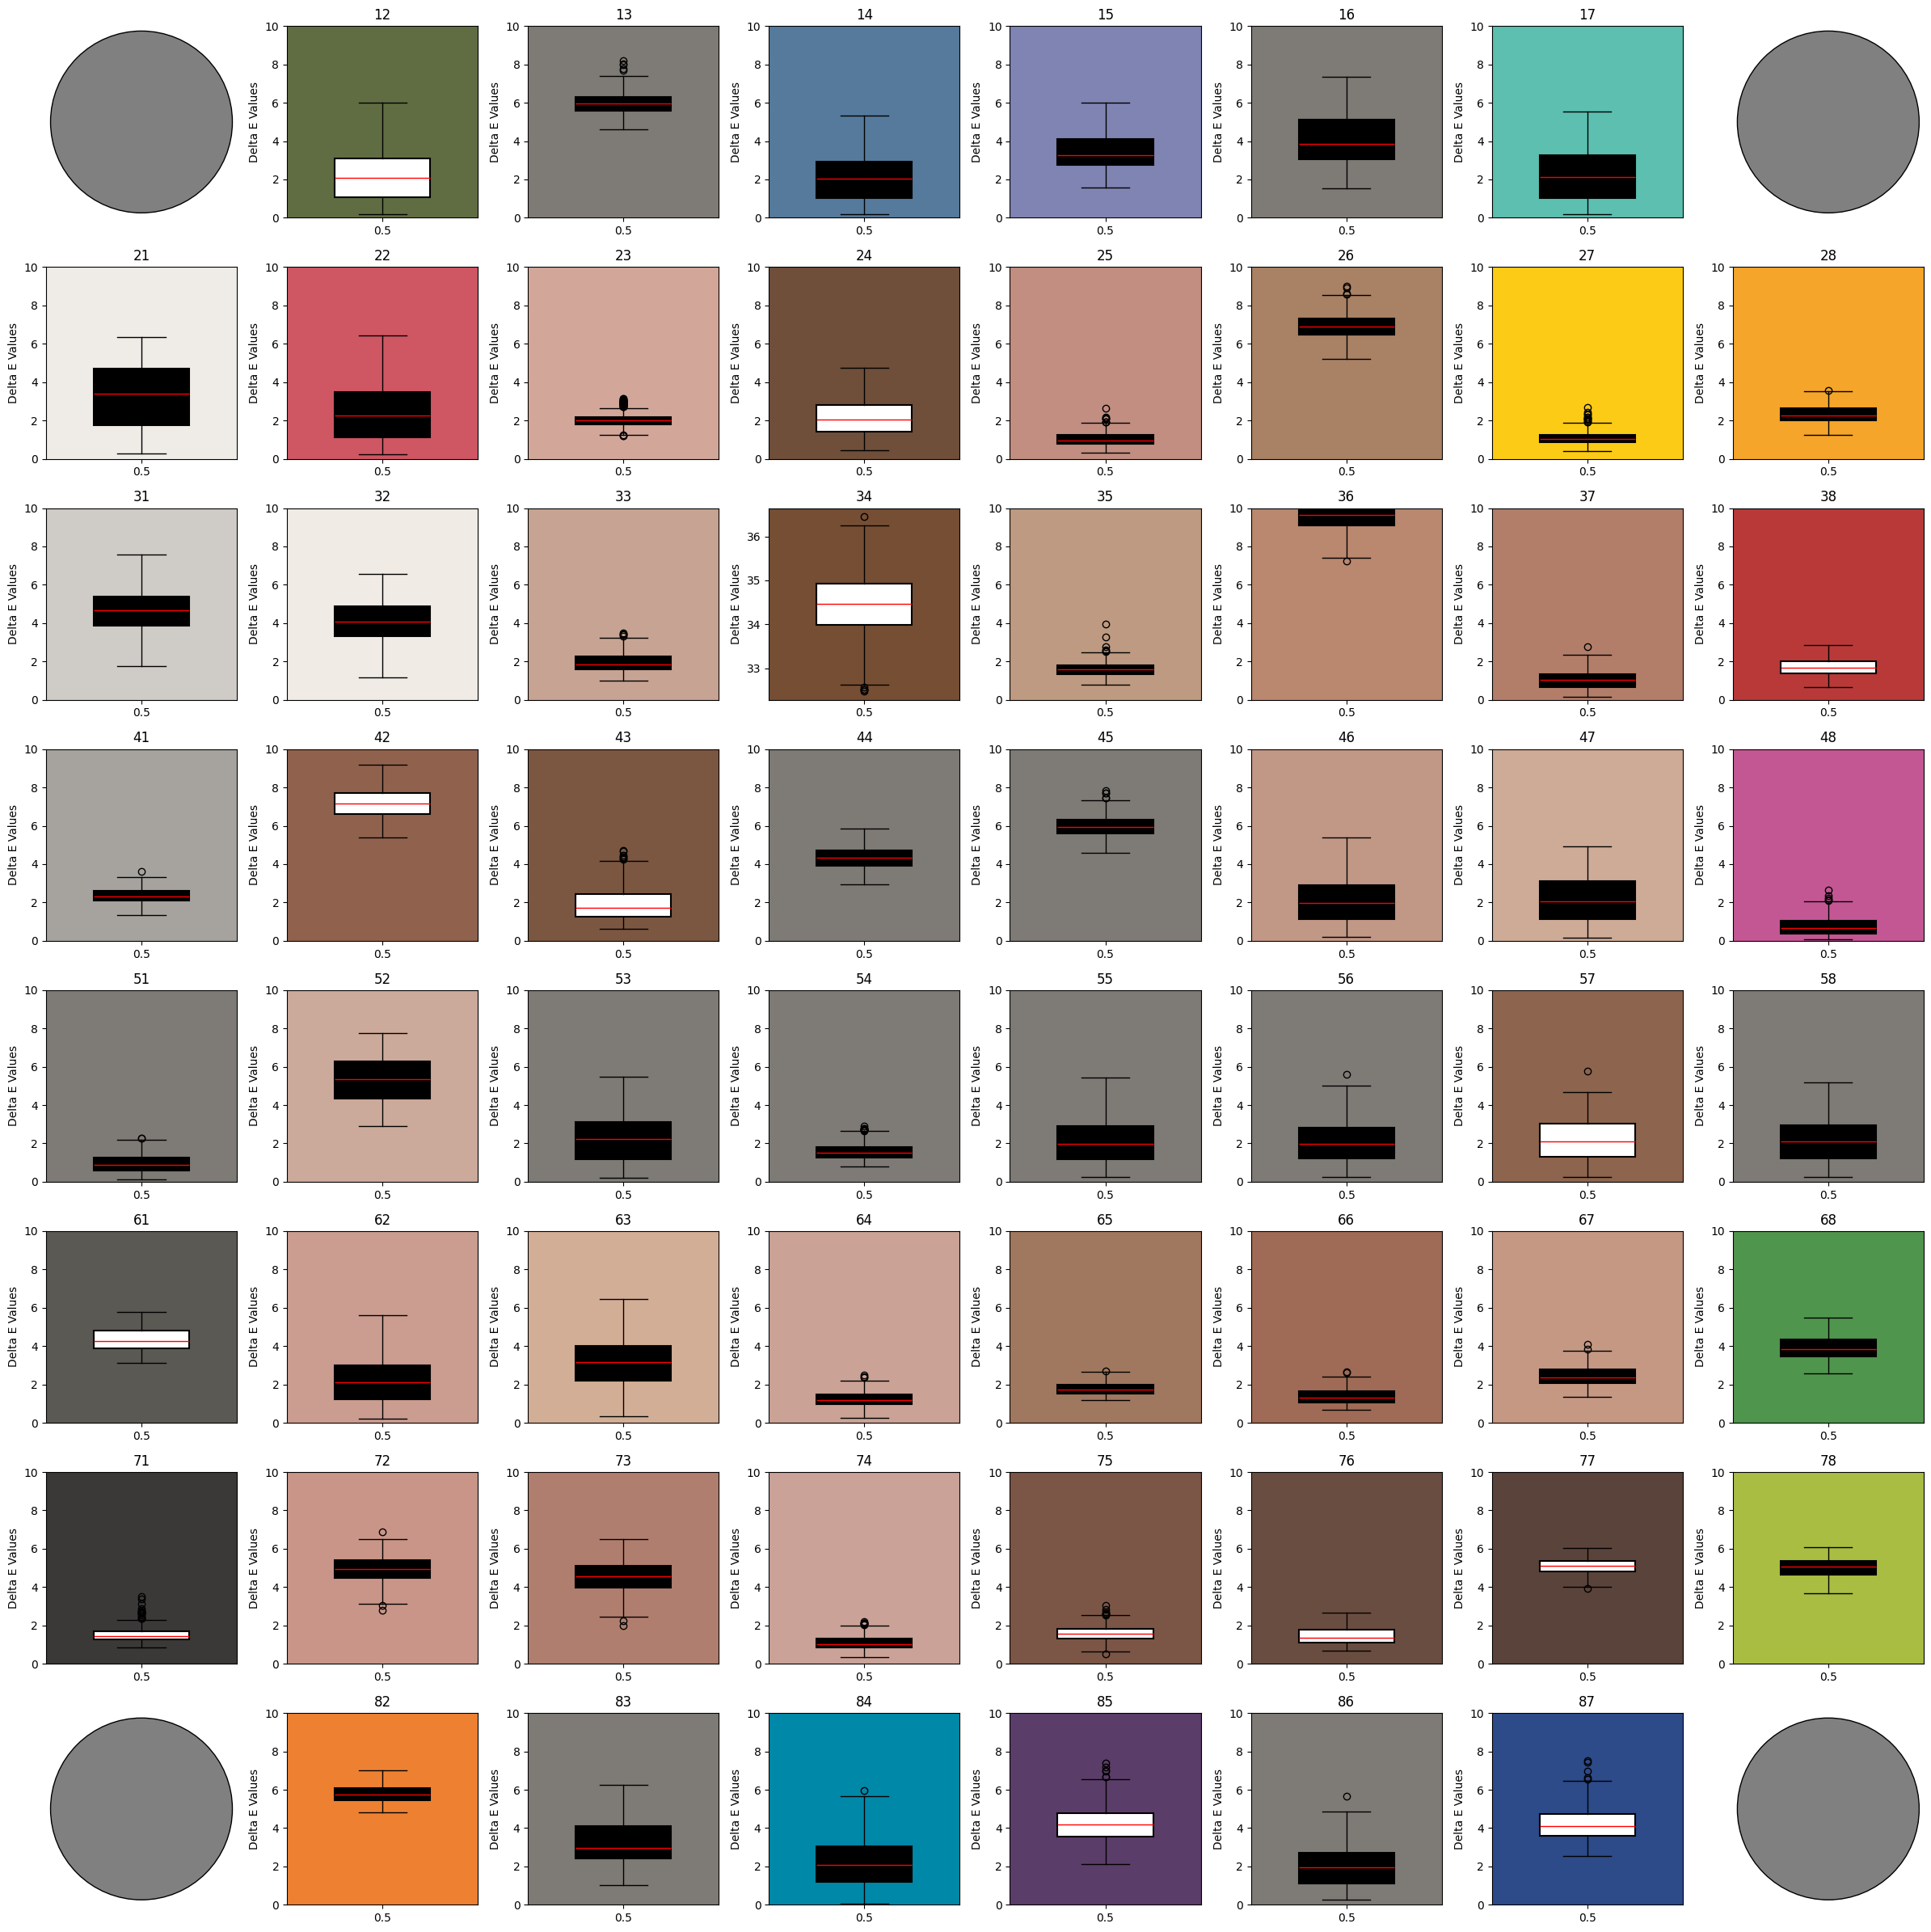

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import colorspacious as cs

fig, axes = plt.subplots(8, 8, figsize=(24, 24))

max_error = np.max(delta_e_values)

j = 0
for row in range(1, 9):
    for col in range(1, 9):
        ax = axes[row - 1, col - 1]
        spot = row * 10 + col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5, 10.5])
            ax.set_ylim([-10.5, 10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)
        ax.set_facecolor(master_color)

        hist_color = 'white' if L_master < 47 else 'black'
        # Change histogram to boxplot, centered
        ax.boxplot(delta_e_values[:, j], patch_artist=True, boxprops=dict(facecolor=hist_color, color='black', linewidth=1.5), medianprops=dict(color='red'), widths=0.5, positions=[0.5])

        ax.set_xlim([0, 1])  # Center the boxplot
        if spot != 34:
            ax.set_ylim([0, 10])
        ax.set_ylabel('Delta E Values')
        ax.set_xlabel('')
        ax.set_title(str(spot))
        j += 1

plt.tight_layout()
plt.savefig('figures/delta_e_boxplots.png')


#### 3.4 Scatter: print master vs measurements  <a class="anchor" id="3.4"></a>

To assess whether the print measurements differ from the intended values in a systematic way on the level of L, a and b values, we chose to create scatter plots for each value respectively. In the plots, the x-axis relates to the intended value (the print master value) and the y-axis relates to the measurement values. Thus, in a perfect "print measurement" scenario, all data points would lie on the line of the function `y = x`. Points lying above that line have an actual print measurement above the intendeded value and vice versa. For easier interpretation, the line of `y = x` is added to the plots.

For the `L`-value, we can only conclude that more points lie below the line than above. Thus, the `L` values of the measurements tend to be a bit lower than intended (on average). There is one outlier for `L` around 93 where the measurement value is way lower that aimed for. Also, it is obvious that the measurement values for very low `L` values are all lower than the intended values. 

This last aspect of the `L` plot can be said for the `a` and `b` plots too: Here the lower values are also printed below the target with the tendency to the opposite for mid and higher values. `a` and `b` do not display any outliers.

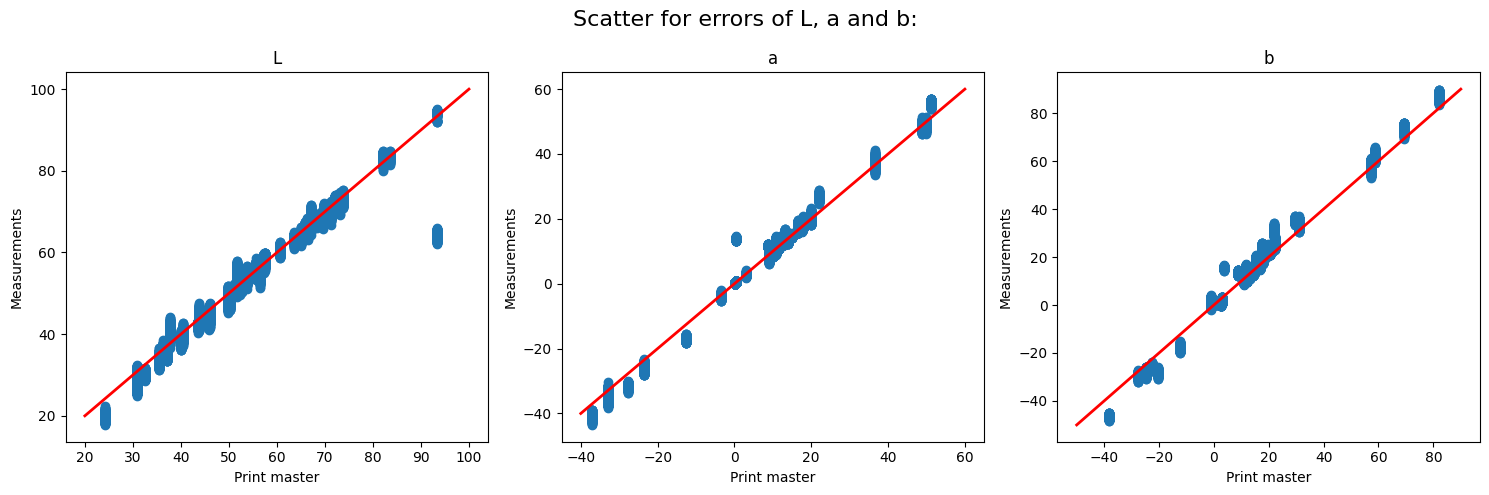

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(["L", "a", "b"]):
    x, y = create_scatter_data(master_colors, measurements, color)
    axes[i].scatter(x, y)
    if color == "L":
        axes[i].plot([20, 100], [20, 100], color='red', linestyle='-', linewidth=2)
    elif color == "a":
        axes[i].plot([-40, 60], [-40, 60], color='red', linestyle='-', linewidth=2)
    else:
        axes[i].plot([-50, 90], [-50, 90], color='red', linestyle='-', linewidth=2)
    axes[i].set_title(f"{color}")
    axes[i].set_xlabel("Print master")
    axes[i].set_ylabel("Measurements")

fig.suptitle("Scatter for errors of L, a and b:", fontsize=16)
plt.tight_layout()
plt.show()

#### 3.5 Standard Deviations of color values (L, a, b) (colored by cluster) (grey duplicates filtered out)  <a class="anchor" id="3.5"></a>

We chose to add another, similar looking figure to visualise the dispersion of the three color values `L`, `a` and `b`. We computed the standard deviation of each respective value for each individual color spot. We thus get one standard deviation per color value and color spot. To add an interpretational level, we colored the scatter points. The data points are grouped by their color and assigns them to their cluster, we derived using K-Means with K=4. This choice would allow interpretations such as "similar colors display similar dispersions".

For `L` we see that the standard deviations lie between 0.4 and 1.4. The `L` values to the very low and very high end of the spectrum display a lower dispersion (standard deviation) than the middle values. However, in the middle part, we find standard deviations in the whole scale of the plot, indicating that middle `L` values disperse quite differently. Dispersion here is most likely not correlated with the `L`value. In terms of color-clusters, we see that the violet cluster has a low dispersion on average (way more low dispersion points than high dispersion points). The dispersion of the green cluster is higher on average than the violet one. The other two clusters don't have many points and it is difficult to see a proper tendency here.

Leaving the clusters aside, it becomes obvious that most color spots with an `a` value between 0 and 20 have a really low dispersion. Note that the scale for the `a` scatter starts at 0 (and goes up to 1.6). The green and the violet clusters lie on top of each other, mostly in this area. The clusters yellow and blue display rather higher dispersions, the yellow one more extrem than the blue cluster. There is one violet outlier with a high standard deviation of roughly 1.6.

The scale of the `b` scatter plot ranges from 0,2 to 1,8. Many points of the green and violet clusters have a really low dispersion again. The yellow cluster with a relative high `b` value has a notably higher dispersion than the other clusters. The blue cluster, with points with rather low `b` values, have obviously the second highest dispersion (on cluster average level).

/home/tkbischoff/venvs/DS/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


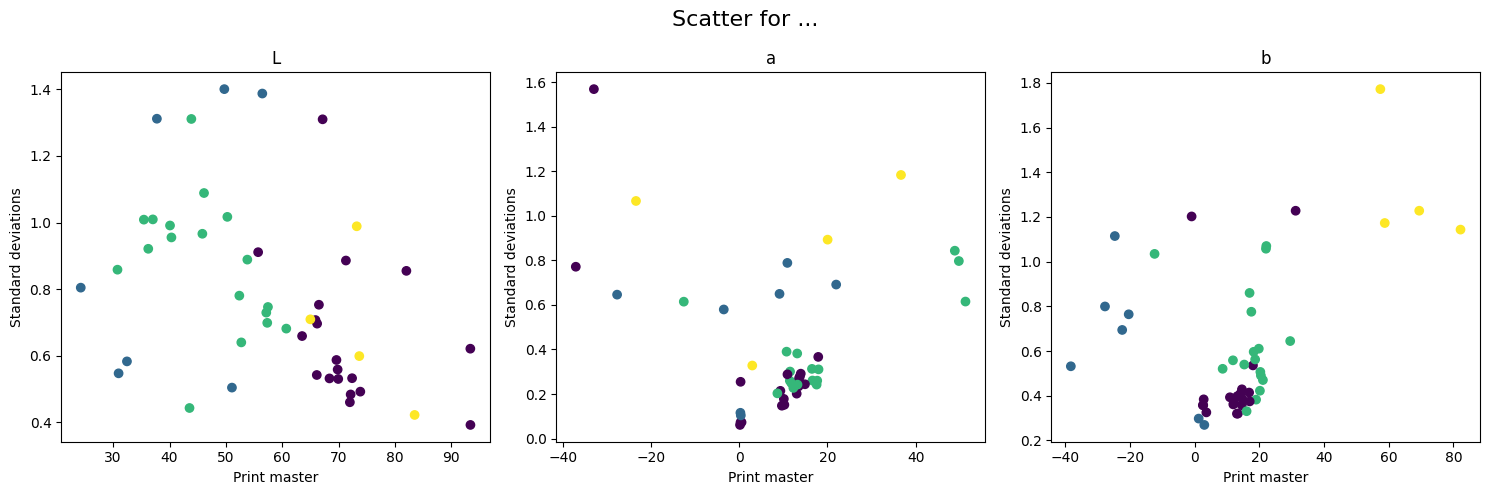

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(["L", "a", "b"]):
    x, y, c = create_scatter_data_std(df_stds, master_colors_filtered, color)
    if c:
        axes[i].scatter(x, y, c=c, cmap="viridis")
    else:
        axes[i].scatter(x, y)
    axes[i].set_title(f"{color}")
    axes[i].set_xlabel("Print master")
    axes[i].set_ylabel("Standard deviations")

fig.suptitle("Scatter for ...", fontsize=16)
plt.tight_layout()
plt.show()